# Segmentación K-means modificado + superpixels

En este notebook vamos a continuar con aspectos más avanzados en la segmentación de imágenes. En primer lugar vamos a implementar el algoritmo k-means con la modificación de la función de coste que incorpora información espacial.

El desarrollo de esta práctica va a ser función a función, así que tendréis que ir rellenando las funciones siguiendo las especificaciones de las mismas. 

En general, vamos a probar esta práctica en imágenes en color. Para ello, vamos a manejar las siguientes variables:
- imagen: matriz de $filas \times columnas \times 3$ que representa la imagen que queremos segmentar
- medias: matriz de $filas \times columnas \times 3$ que representa la imagen original filtrada mediante un filtro de la media aritmética de dimensión $S\times S$ (fijado por el usuario)
- centros: matriz de $K\times 3$, donde $K$ es el número de clusteres en los que queremos segmentar la imagen (fijado por el usuario)
- labels: matriz de $filas\times columnas$ que contiene, para cada píxel, un número entre $0$ y $K-1$ que representa al cluster al que asignamos dicho píxel
- segmentada: matriz de $filas\times columnas\times 3$, donde cada píxel contiene el color medio del cluster al que hemos asignado dicho píxel (no confundir con el valor del centro)
- Otros parámetros: $S$ dimensión del filtro de la media; $K$ número de clústeres; $alpha$ importancia de la información espacial

In [28]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

La función crea_imagen_medias ya está programada. Esta función se encarga de realizar un filtro de la media aritmética de dimensión $S\times S$ sobre una imagen cualquiera (en escala de grises o en color).

In [29]:
def crea_imagen_medias(imagen, S):
    a = S//2
    filas, columnas = imagen.shape[0:2]
    imagen_amp = cv2.copyMakeBorder(imagen, a, a, a, a, cv2.BORDER_REPLICATE)
    medias = np.zeros(imagen.shape)
    for i in range(a, filas+a):
        for j in range(a, columnas + a):
            medias[i-a, j-a] = imagen_amp[i-a:i+a+1, j-a: j+a+1].mean(axis = (0,1))
    return medias

Programa la función **crea_centros_aleatorios**. La función obtiene K números aleatorios entre 0 y el número de filas; K números aleatorios entre 0 y número de columnas y devuelve dichos píxeles como centros iniciales. En caso de ser una imagen en escala de grises devolverá un vector de K elementos. Si es una imagen en color devolverá un vector de $K\times 3$

In [30]:
def crea_centros_aleatorios(imagen, K):
    filas, columnas = imagen.shape[0:2]
    puntos_y = np.random.randint(0,filas, size=K)
    puntos_x = np.random.randint(0,columnas,size=K)
    centros = imagen[puntos_y,puntos_x]    
    return centros

Ejecuta la siguiente celda y comprueba centros es
[[ 68  62 125]
 [169  27  51]
 [227 218 251]
 [133  87 144]
 [157 109  86]]

In [31]:
np.random.seed(seed=1)
centros = crea_centros_aleatorios(np.random.randint(0, high =255, size=(100,100, 3)), 5)
print (centros)

[[ 68  62 125]
 [169  27  51]
 [227 218 251]
 [133  87 144]
 [157 109  86]]


Programa la función clasifica. Esta función recibe la imagen original, la imagen de medias, los centros y alpha y obtiene la imagen de etiquetas (a qué cluster entre 0 y K-1 pertenece cada píxel). Utiliza las fórmulas de asignación de clusters que aparece en teoría.

Esta función se puede hacer de múltiples formas. Yo te propongo una en que solo debes programa un único bucle for desde 1 hasta K. Para ello puedes crear una matriz auxiliar de distancias de dimensión $filas \times columnas \times K$. En la $i$-ésima capa calcularás la distancia de cada píxel con el centro $c_i$. Por último, puedes hacer un argmin en la dimensión de la profundidad para obtener de una sola vez todas las etiquetas.

In [5]:
def clasifica(imagen, medias, K, centros, alpha):
    distancias = np.zeros((imagen.shape[0],imagen.shape[1],K))

    for i in range(K):
        dist_color = np.sum((imagen - centros[i])**2, axis=2)
        dist_media = np.sum((medias - centros[i])**2, axis=2)
        distancias[:,:,i] = dist_color + (alpha * dist_media)
    
    labels = np.argmin(distancias, axis = 2)
    
    return labels

Programa la función coste. La función recibirá la imagen, medias, labels, centros y alpha. La función calculará el coste del sistema atendiendo a las fórmulas vistas en teoría.

In [6]:
def coste(imagen, medias, labels, centros, alpha):
    dist_color = (imagen - centros[labels])**2
    dist_media = (medias - centros[labels])**2
    J = np.sum(dist_color + (alpha * dist_media))
    return J

Ejecuta la siguiente celda y comprueba si el coste es $290847007.58$

In [7]:
np.random.seed(seed=1)
im  = np.random.randint(0, high =255, size=(100,100, 3))
centros = crea_centros_aleatorios(im, 2)
medias = crea_imagen_medias(im, 3)
labels = clasifica(im, medias, 2, centros, 1)
J = coste(im,medias, labels, centros, 1)
print (J)

290847007.5802469


Programa la función actualiza_centros. Utiliza las fórmulas de teoría para modificar la matriz de centros. 

Recuerda que puedes hacer esta función utilizando un único bucle for que itere sobr el número de clusteres, en lugar de iterar sobre los píxeles de la imagen.

In [20]:
def actualiza_centros(imagen, medias, labels, centros, K, alpha):
    new_centers = centros.copy()
    for k in range(K):
        mask = (labels == k)
        num_pixels = np.sum(mask)
        if num_pixels >0:
            numerador = np.sum(imagen[mask] + alpha * medias[mask],axis=0)
            denominador = num_pixels * (1 + alpha)
            new_centers[k] = numerador / denominador
        
    return centros

Programa ahora la función crea_imagen_final. Básicamente esta función es muy parecida a una que hicimos en la práctica anterior. La idea es crear una nueva imagen en la que en cada píxel aparezca el color medio de los píxeles que pertenezcan al mismo cluster que él.

In [9]:
def crea_imagen_final(imagen, labels, K):
    if len(imagen.shape) == 3:
        centros = np.zeros((K, imagen.shape[2]))
    else:
        centros = np.zeros(K)

    for i in range(K):
        mask = (labels == i)
        if np.any(mask):
            if len(imagen.shape) == 3:
                centros[i] = np.mean(imagen[mask], axis = 0)
            else:
                centros[i] = np.mean(imagen[mask])

    return centros[labels]

Por último, vamos a crear la función kmeans_modificado. Esta función general recibe los parámetros fijados por el usuario (imagen, K, alpha y S) y va llamando a las funciones anteriores. Como criterio de parada, establece que en dos iteraciones consecutivas la diferencia en el coste sea menor a $10^{-5}$. Por último la función devuelve labels, centros y la imagen segmentada. 

In [22]:
def kmeans_modificado(imagen, K, alpha, S):
    imagen = np.float32(imagen)
    #Genera la imagen medias
    medias = crea_imagen_medias(imagen,S)
    #Genera la matriz de centros
    centros = crea_centros_aleatorios(imagen, K)
    #Genera la imagen labels
    labels = clasifica(imagen, medias, K, centros, alpha)
    
    coste_ant = np.Infinity
    coste_act = coste(imagen, medias, labels, centros, alpha)
    
    while (coste_ant-coste_act)>10**-5:
        coste_ant = coste_act
        #Actualiza centros
        centros = actualiza_centros(imagen, medias, labels, centros, K, alpha)
        #Actualiza labels
        labels = clasifica(imagen, medias, K, centros, alpha)
        #Actualiza coste_act
        coste_act = coste(imagen, medias, labels, centros, alpha)

    #Genera la imagen segmentada
    segmentada = np.uint8(crea_imagen_final(imagen, labels, K))

    return labels, centros, segmentada

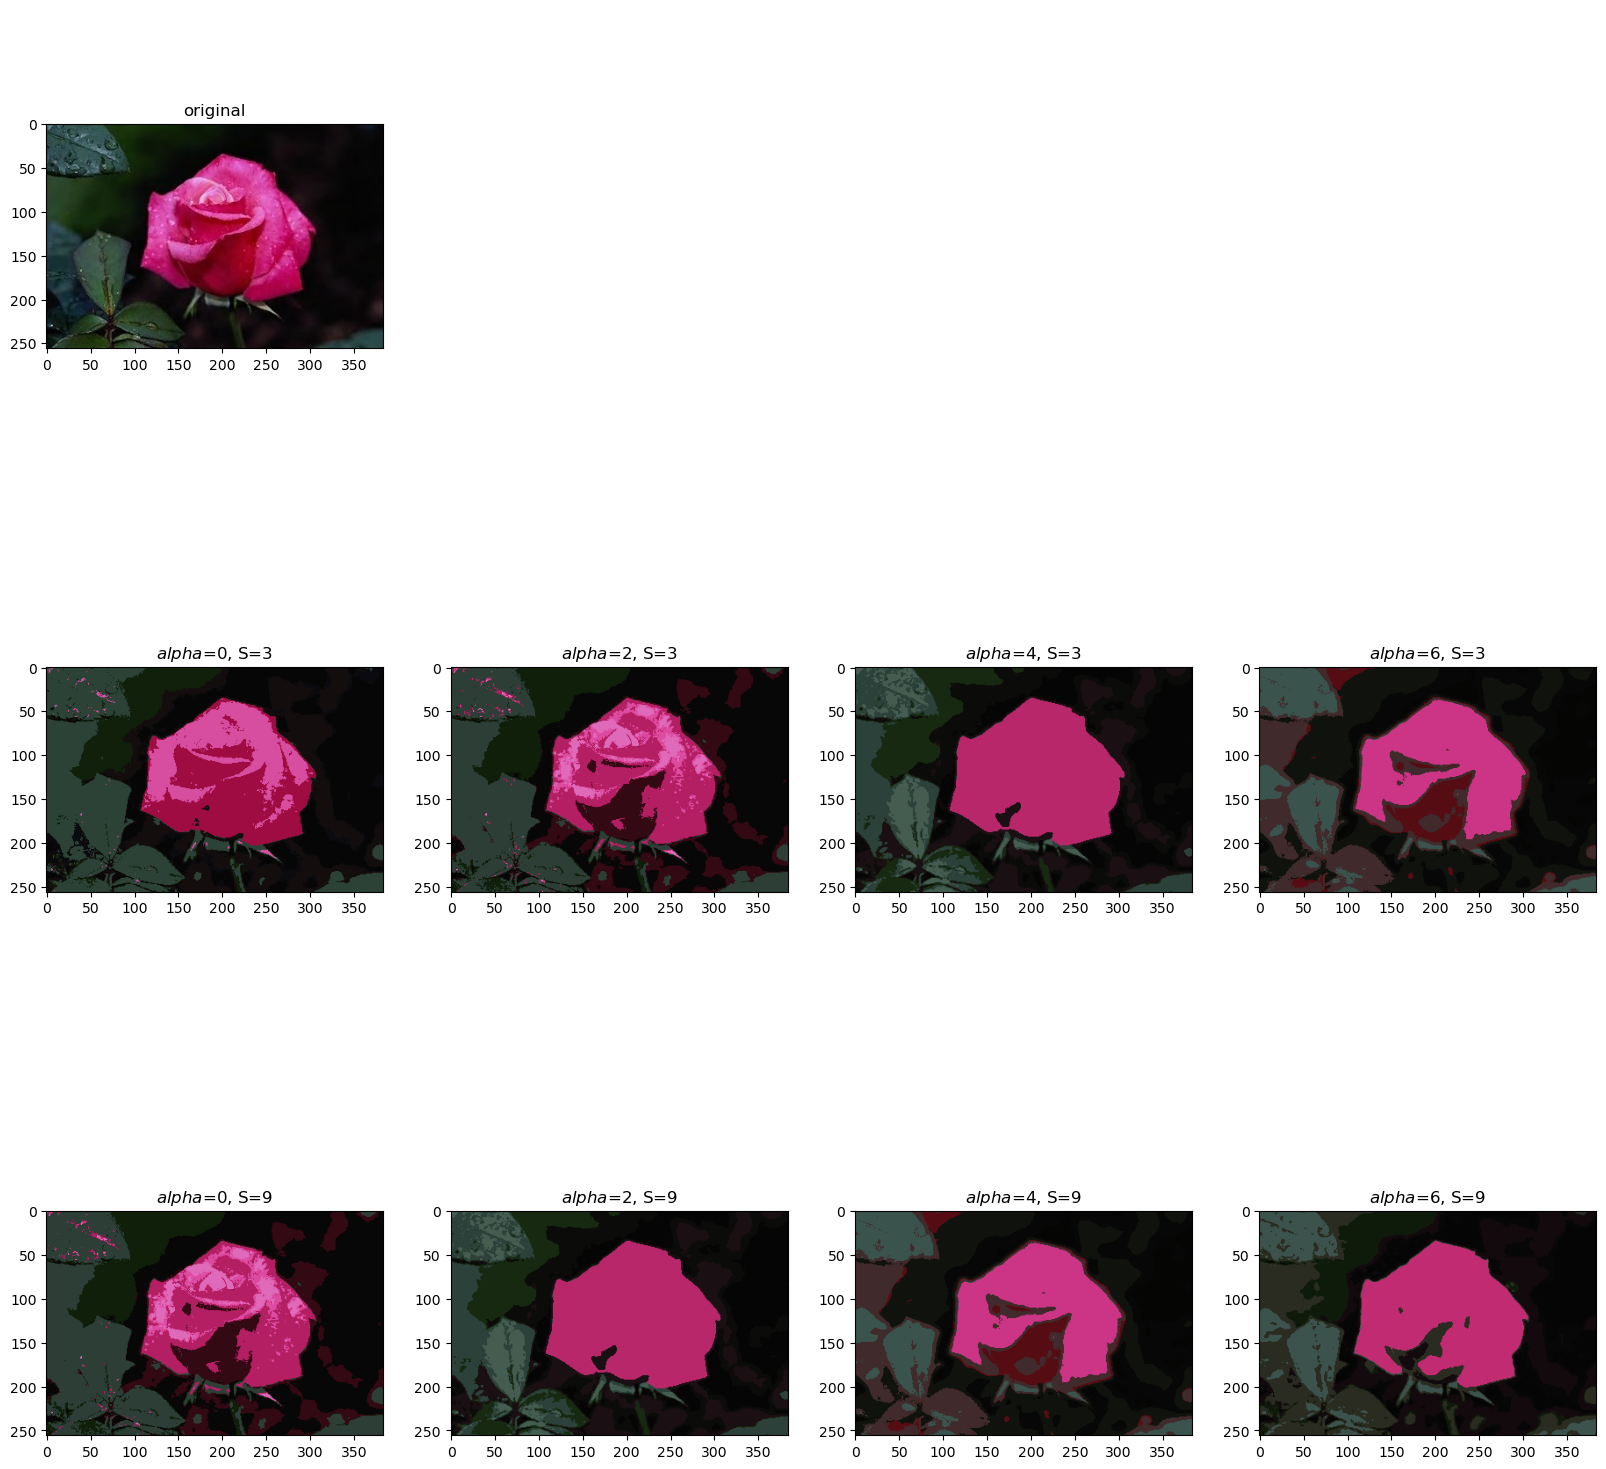

In [23]:
img = cv2.imread('images/645.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

alphas = [0, 2, 4, 6]
S = [3, 9]

imgs = [img]

for alpha in alphas:
    for s in S:
        _,_, segmentada = kmeans_modificado(img, 7, alpha, s)
        imgs.append(segmentada)

fig, axes = plt.subplots(1+len(S), len(alphas), figsize=(20,20))

axes[0][0].imshow(img.astype(np.uint8))
axes[0][0].set_title("original")
axes[0][1].set_axis_off()
axes[0][2].set_axis_off()
axes[0][3].set_axis_off()

for i in range(1, 1+len(S)):
    for j in range(len(alphas)):
        axes[i][j].imshow(imgs[i+j].astype(np.uint8))
        axes[i][j].set_title(f"$alpha$={alphas[j]}, S={S[i-1]}")


Realiza ahora pruebas con alguna de las imágenes subidas (645.jpg, por ejemplo). Comprueba las diferencias entre utilizar un factor $alpha=0$ e ir aumentándolo. Comprueba también cómo afecta el parámetros $S$ a las segmentaciones obtenidas

# Superpíxeles

En esta última parte de la práctica vamos a utilizar una función para obtener una imagen de superpíxeles aplicando el algoritmo visto en clase (llamado SLIC). 

In [25]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

Investiga brevemente la función slic de scikit-image. Podemos llamar a la función con 2 parámetros
- imagen sobre la que queremos aplicar la segmentación de superpíxeles
- n_segments: número aproximado de superpíxeles que queremos obtener
La función devuelve una imagen de etiquetas en las que aparece el índice del superpíxel correspondiente. 

Para visualizar los superpíxeles vamos a utilizar dos métodos. El primero de ellos utiliza la función mark_boundaries. Esta función recibe la imagen  originak y la imagen de superpíxeles y devuevle una imagen en la que aparecen pintadas las fronteras entre superpíxeles. La segunda sería utilizando la función crea imagen final que ya has programado antes.

Prueba ambos métodos con la imagen playa.jpg y distinto número de superpíxeles. Comprueba las imágenes obtenidas.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


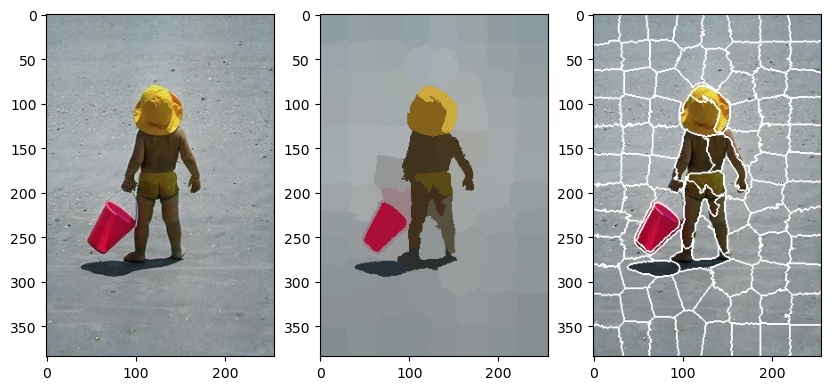

In [27]:
image = cv2.imread('images/152.jpg',1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
K = 100

labels = slic(image, K)
segmentada = mark_boundaries(image, labels, K)

img = crea_imagen_final(image, labels, K)

fig, axes = plt.subplots(1,3, figsize=(10,10))
axes[0].imshow(image)
axes[1].imshow(img.astype(np.uint8))
axes[2].imshow(segmentada)
plt.show()